## Importação da bibliotecas

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import keras
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers import Input, Embedding
from keras.models import Model
from keras.regularizers import l2
from keras.layers.core import Flatten, Dense, Dropout
from keras.optimizers import SGD, RMSprop, Adam

np.set_printoptions(formatter={'float': '{: 0.1f}'.format})


## Movielens dataset

- [Movielens - Readme](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)
- Movielens - Small data set - 100.000 avaliações:[ml-latest-small.zip](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015).


In [17]:
batch_size=64

## Leitura dos Dados - Movielens dataset

Caso a célula a seguir falhar, é necessário executar o notebook:
- [Movielens Dataset](MovieLens_dataset.ipynb)

In [18]:
data = np.load('../data/movielens_ordered.npz')
ratings,movie_names = data['arr_0']
n_samples = ratings.shape[0]

In [19]:
h_userId = np.bincount(ratings[:,0].astype(np.int))
n_users = h_userId.size
h_movieId = np.bincount(ratings[:,1].astype(np.int))
n_movies = h_movieId.size

## Divisão dos dados em treinamento e validação

In [20]:
user_min, user_max, movie_min, movie_max = (ratings[:,0].min(), 
                                            ratings[:,0].max(), 
                                            ratings[:,1].min(), 
                                            ratings[:,1].max())
user_min, user_max, movie_min, movie_max

(0.0, 670.0, 0.0, 9065.0)

In [21]:
n_users, n_movies, n_samples

(671, 9066, 100004)

This is the number of latent factors in each embedding.

In [22]:
n_factors = 50

In [23]:
np.random.seed = 42

Randomly split into training and validation.

In [24]:
msk = np.random.rand(n_samples) < 0.8
train = ratings[msk]
valid = ratings[~msk]
print('train:',train.shape[0],' amostras:\n',train[:5])
print('valid:',valid.shape[0],' amostras:\n',valid[:5])

train: 79959  amostras:
 [[ 0.0  30.0  2.5]
 [ 0.0  833.0  3.0]
 [ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  931.0  4.0]]
valid: 20045  amostras:
 [[ 0.0  1047.0  2.0]
 [ 0.0  1111.0  2.5]
 [ 0.0  2925.0  3.0]
 [ 1.0  16.0  5.0]
 [ 1.0  49.0  3.0]]


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [25]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(movie_in)
x = keras.layers.dot([u, m],axes=-1)
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550                                        
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300                                       
___________________________________________________________________________________________

In [26]:
train_userId = train[:,0]
train_movieId = train[:,1]
train_rating = train[:,2]
print('train shapes:',train_userId.shape, train_movieId.shape, train_rating.shape)

valid_userId = valid[:,0]
valid_movieId = valid[:,1]
valid_rating = valid[:,2]
print('valid shapes:',valid_userId.shape, valid_movieId.shape, valid_rating.shape)

train shapes: (79959,) (79959,) (79959,)
valid shapes: (20045,) (20045,) (20045,)


In [27]:
model.fit([train_userId, train_movieId], train_rating, 
          batch_size=64, epochs=1, 
          validation_data=([valid_userId, valid_movieId], valid_rating))

Train on 79959 samples, validate on 20045 samples
Epoch 1/1
79959/79959 [==============================] - 26s - loss: 9.9489 - val_loss: 4.2893

The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [28]:
model.predict([np.array([3]), np.array([6])])

array([[ 3.2]], dtype=float32)

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [29]:
user_in = Input(shape=(1,),dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(user_in)

movie_in = Input(shape=(1,),dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(movie_in)

In [30]:
x = keras.layers.concatenate([u, m])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')
print(nn.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 1, 50)         33550                                        
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 1, 50)         453300                                       
___________________________________________________________________________________________

In [ ]:
nn.fit([train_userId, train_movieId], train_rating, batch_size=64, epochs=8, # was 8 
          validation_data=([valid_userId, valid_movieId], valid_rating))

Train on 79959 samples, validate on 20045 samples
Epoch 1/8
79959/79959 [==============================] - 30s - loss: 2.5278 - val_loss: 0.9169

This improves on our already impressive accuracy even further!

In [32]:
nn.predict([np.array([3]), np.array([6])])

array([[ 4.1]], dtype=float32)

## Calculando e visualizando as predições para todos os outros usuários/filmes

In [33]:
grid_ratings = -1. * np.ones((n_users,n_movies))
uId = (ratings[:,0]).astype(np.int)
mId = (ratings[:,1]).astype(np.int)
grid_ratings[uId,mId] = ratings[:,2] # Criação da matriz
print(grid_ratings.shape)

(671, 9066)


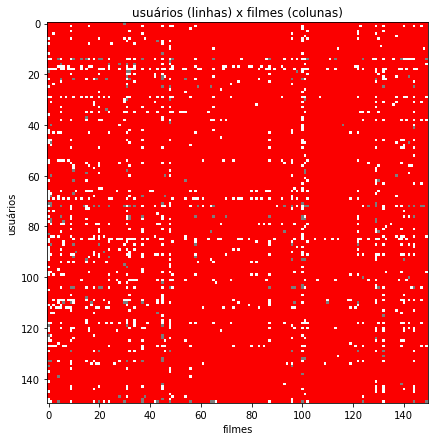

In [40]:
show_ratings = np.zeros((n_users,n_movies,3))
show_ratings[:,:,0] = np.where(grid_ratings == -1., 5, grid_ratings)
show_ratings[:,:,1] = np.where(grid_ratings == -1., 0., grid_ratings)
show_ratings[:,:,2] = np.where(grid_ratings == -1., 0., grid_ratings)


import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(show_ratings[:150,:150,:])
plt.xlabel('filmes')
plt.ylabel('usuários')
plt.show()

In [41]:
#n_predict = 102400
n2p_user,n2p_movie = np.nonzero(grid_ratings==-1)
recommend = nn.predict([n2p_user, n2p_movie])

In [42]:
gg = grid_ratings.copy()
gg[n2p_user,n2p_movie] = recommend[:,0]



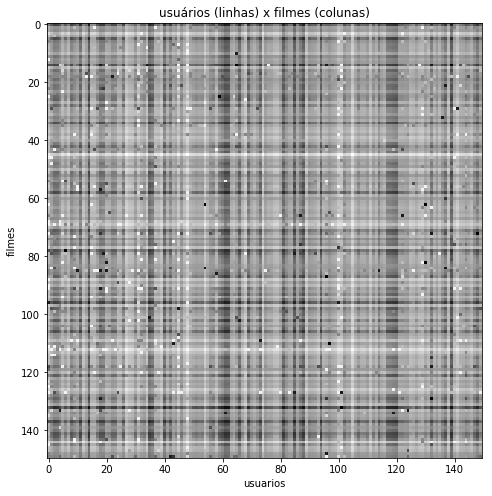

In [43]:
plt.figure(figsize=(8,8))
plt.title('usuários (linhas) x filmes (colunas)')
plt.xlabel('usuarios')
plt.ylabel('filmes')
plt.imshow(gg[:150,:150],cmap='gray')
plt.show()

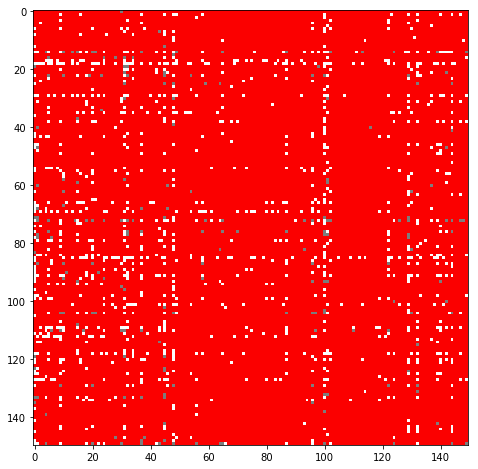

In [44]:
plt.figure(figsize=(8,8))
plt.imshow(show_ratings[:150,:150,:])

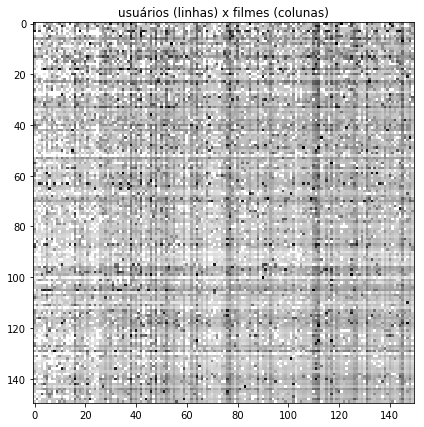

In [47]:
io_popular_movies = np.argsort(h_movieId)[::-1]
io_top_users = np.argsort(h_userId)[::-1].astype(np.int)
gg_ord = gg[np.ix_(io_top_users,io_popular_movies)]
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(gg_ord[:150,:150],cmap='gray')
plt.show()

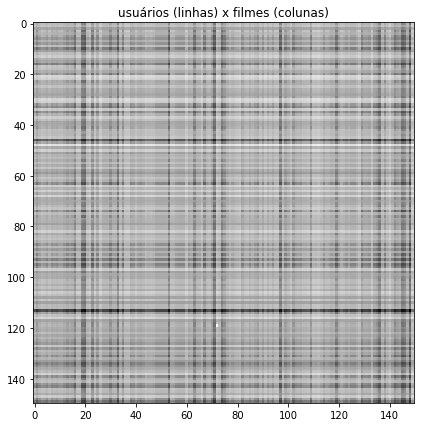

In [48]:
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(gg_ord[-150:,-150:],cmap='gray')
plt.show()

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [50]:
topMovies = io_popular_movies[:2000]

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

We can now do the same thing for the embeddings.

In [51]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [53]:
fac0 = movie_pca[0]
isort = np.argsort(fac0)[::-1]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [54]:
for ii in isort[:15]:
    print(fac0[ii],movie_names[ii])

0.0580809446309 Cobb (1994)
0.0570193317213 Othello (1995)
0.0568426734112 Little Women (1994)
0.0565835763632 Spirits of the Dead (1968)
0.0564276265334 Grumpier Old Men (1995)
0.0564136785267 Star Wars: Episode V - The Empire Strikes Back (1980)
0.055803706762 Fatal Instinct (1993)
0.0552663184769 Before the Rain (Pred dozhdot) (1994)
0.0532951087646 Fly II, The (1989)
0.0526521624126 Nixon (1995)
0.0525682700493 Flintstones, The (1994)
0.052262327254 Powder (1995)
0.0521487512647 This Is Spinal Tap (1984)
0.0520350658989 Ready to Wear (Pret-A-Porter) (1994)
0.0517265486806 Sudden Death (1995)


In [55]:
for ii in isort[-15:]:
    print(fac0[ii],movie_names[ii])

-0.0459714205741 Caught (1996)
-0.0460044015108 Friday the 13th Part VII: The New Blood (1988)
-0.0465433412437 Doors, The (1991)
-0.046880565377 Saboteur (1942)
-0.0482363086891 Star Trek II: The Wrath of Khan (1982)
-0.0483043527208 E.T. the Extra-Terrestrial (1982)
-0.0486320893313 Police Academy 3: Back in Training (1986)
-0.0488508047504 Elizabeth (1998)
-0.0498624278476 Godzilla (Gojira) (1954)
-0.0517025925745 Bullets Over Broadway (1994)
-0.0535561976512 Police Academy 4: Citizens on Patrol (1987)
-0.0537669196266 Antz (1998)
-0.0578402639189 Wings of the Dove, The (1997)
-0.0591583971658 Mulan (1998)
-0.0603260039794 Back to the Future Part II (1989)


The 2nd is 'hollywood blockbuster'.

In [56]:
fac1 = movie_pca[1]
isort = np.argsort(fac1)[::-1]

In [57]:
for ii in isort[:15]:
    print(fac1[ii],movie_names[ii])

0.0786207806293 I Love Trouble (1994)
0.068264096679 Manhattan Murder Mystery (1993)
0.067657622484 Inkwell, The (1994)
0.0676412769476 Raw Deal (1948)
0.0661762923833 Phantoms (1998)
0.065866293012 Bitter Moon (1992)
0.0644775509709 Safe Passage (1994)
0.063949287474 Davy Crockett, King of the Wild Frontier (1955)
0.0630624153373 American Buffalo (1996)
0.0628806459647 Foreign Correspondent (1940)
0.0622577889638 Poltergeist II: The Other Side (1986)
0.0619505275902 My Fellow Americans (1996)
0.0610596988634 Crimson Tide (1995)
0.0603809432381 Little Lord Fauntleroy (1936)
0.0593535937551 Red Firecracker, Green Firecracker (Pao Da Shuang Deng) (1994)


In [58]:
for ii in isort[-15:]:
    print(fac1[ii],movie_names[ii])

-0.0490596315923 Kurt & Courtney (1998)
-0.0492163872022 Trainspotting (1996)
-0.0498110435838 Aliens (1986)
-0.0498726307675 Stage Fright (1950)
-0.0506188346725 Herbie Goes Bananas (1980)
-0.0507070755813 Striking Distance (1993)
-0.0536422276242 Prefontaine (1997)
-0.0538876599239 Edge, The (1997)
-0.0543194684543 Paradise Lost: The Child Murders at Robin Hood Hills (1996)
-0.0563592300824 Damsel in Distress, A (1937)
-0.0585264054974 Birds, The (1963)
-0.0599664043554 Mixed Nuts (1994)
-0.0620985464381 39 Steps, The (1935)
-0.0622035301179 Inspector General, The (1949)
-0.0650322118948 Léon: The Professional (a.k.a. The Professional) (Léon) (1994)


The 3rd is 'violent vs happy'.

In [59]:
fac2 = movie_pca[2]
isort = np.argsort(fac2)[::-1]

In [60]:
for ii in isort[:15]:
    print(fac2[ii],movie_names[ii])

0.0978094140873 Last Summer in the Hamptons (1995)
0.0806681803435 Interview with the Vampire: The Vampire Chronicles (1994)
0.0803773037185 In the Army Now (1994)
0.0770304412437 Tombstone (1993)
0.0739929488304 Hideaway (1995)
0.07299814408 Heaven & Earth (1993)
0.0716521361305 Shadow, The (1994)
0.0714305346201 Celtic Pride (1996)
0.0680546303141 Outbreak (1995)
0.0667693548673 Street Fighter (1994)
0.0665286664428 Angels and Insects (1995)
0.0665054579112 Third Man, The (1949)
0.0661848213824 Home Alone (1990)
0.0630847958003 Inkwell, The (1994)
0.0628742635023 Mortal Kombat (1995)


In [61]:
for ii in isort[-15:]:
    print(fac2[ii],movie_names[ii])

-0.0545512694495 Carrie (1976)
-0.0546458323849 Run of the Country, The (1995)
-0.0572482894535 Congo (1995)
-0.0573812696703 Benny & Joon (1993)
-0.0574427291663 Starship Troopers (1997)
-0.0579319980693 Man with Two Brains, The (1983)
-0.0589110547932 Best Men (1997)
-0.059097735733 For Whom the Bell Tolls (1943)
-0.059156331838 Live Nude Girls (1995)
-0.0594076559568 She's So Lovely (1997)
-0.0608106631386 Boys on the Side (1995)
-0.0611674086365 Chain Reaction (1996)
-0.0616803790147 Bullets Over Broadway (1994)
-0.0689175936848 Birds, The (1963)
-0.0728589312542 First Wives Club, The (1996)


We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

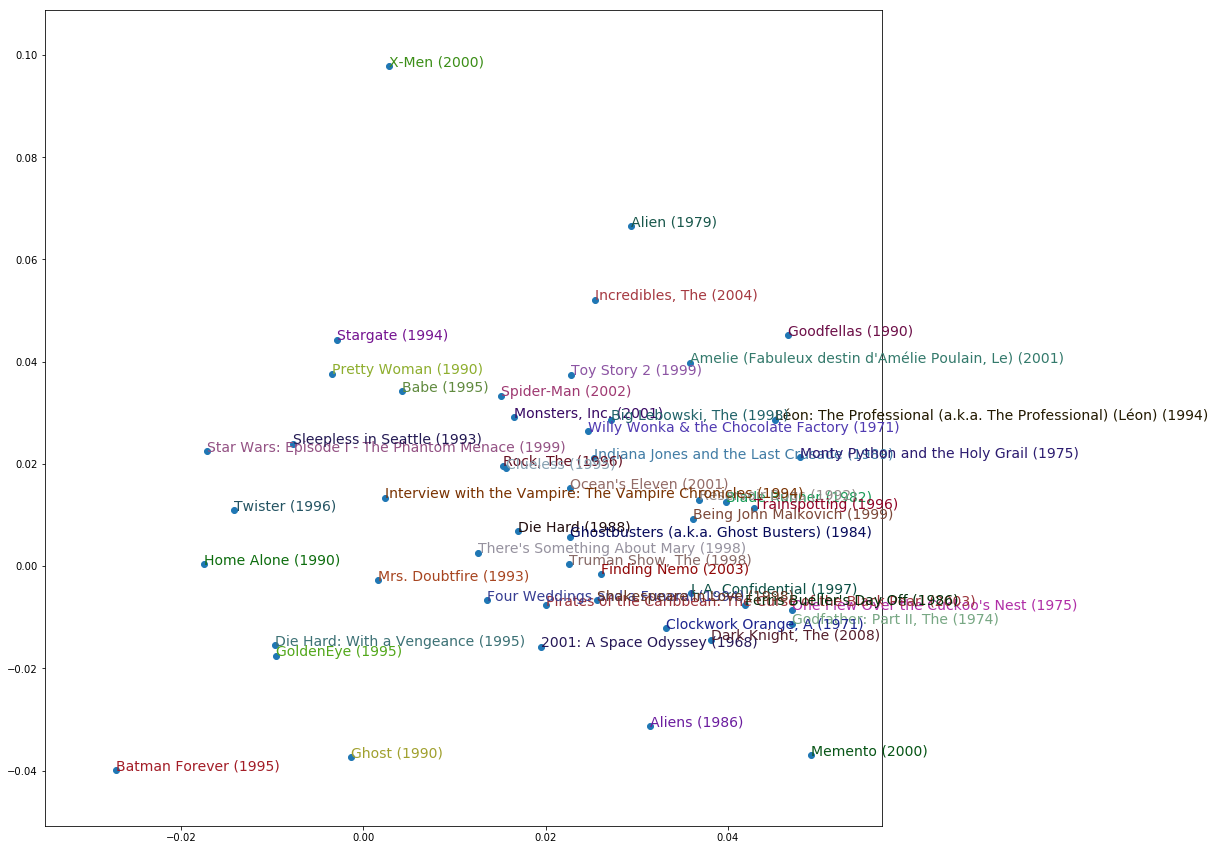

In [63]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()